In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-02-12 14:59:18.398965: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 14:59:18.670542: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 14:59:18.670575: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 14:59:20.194518: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [2]:
funds = [{'fund_cd': '2008010903', 'fund_name': 'SMT TOPIXインデックス･オープン', 'asset_class': '国内株式'}, 
        {'fund_cd': '2008010904', 'fund_name': 'SMT グローバル株式インデックス', 'asset_class': '先進国株式'},
        {'fund_cd': '2008040102', 'fund_name': 'インデックスF海外新興国株式', 'asset_class': '新興国株式'},
        {'fund_cd': '2008010905', 'fund_name': 'SMT 国内債券インデックス･オープン', 'asset_class': '国内債券'},
        {'fund_cd': '2008010906', 'fund_name': 'SMT グローバル債券インデックス', 'asset_class': '先進国債券'},
        {'fund_cd': '2008040103', 'fund_name': 'インデックスF海外新興国債券(1年決算型)', 'asset_class': '新興国債券'}, 
        {'fund_cd': '2008010907', 'fund_name': 'SMT J-REITインデックス･オープン', 'asset_class': '国内リート'},
        {'fund_cd': '2008010908', 'fund_name': 'SMT グローバルREITインデックス', 'asset_class': '先進国リート'}
       ]

In [3]:
fundsdata = pd.read_csv('csv/'+funds[0]['fund_cd']+'.csv')
fundsdata = fundsdata.drop('基準価額', axis=1)
for fund in funds:
    df = pd.read_csv('csv/'+fund['fund_cd']+'.csv')
    df = df.rename(columns={'基準価額': fund['asset_class']})
    fundsdata = pd.merge(fundsdata, df, on='日付')
fundsdata.columns = ['date','jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit']

In [4]:
# 2008~2019年をテストデータにする
funds_test = fundsdata.query('date < 20200101')
funds_dif = funds_test[ ['jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit'] ]
funds_dif = np.log(funds_dif)-np.log(funds_dif.shift(1))
funds_dif = funds_dif.loc[1:]

In [5]:
# ウィンドウ区間の変化率をndarrayに変換
w=30
xlist = []
for i in range(len(funds_dif.index) - w):
    xlist.append(funds_dif.loc[i+1:i+w].values)

In [6]:
x_test = np.stack(xlist,0)

In [7]:
# サンプリング層
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
# VAEエンコーダ部分
latent_dim = 2

encoder_inputs = keras.Input(shape=(w, 8, 1))
x = layers.Conv2D(32, (1,8), activation="softplus", padding="valid")(encoder_inputs)
x = layers.Conv1D(64, 5, activation="softplus", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="softplus")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

2023-02-12 15:03:05.391291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-12 15:03:05.391395: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 15:03:05.391435: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-UBLLJ3A): /proc/driver/nvidia/version does not exist
2023-02-12 15:03:05.391832: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 8, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 1, 32)    288         ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 30, 1, 64)    10304       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 1920)         0           ['conv1d[0][0]']                 
                                                                                            

In [9]:
# VAEデコーダ部分
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(30 * 1 * 64, activation="softplus")(latent_inputs)
x = layers.Reshape((30, 1, 64))(x)
x = layers.Conv2DTranspose(64, (5,1), activation="softplus", padding="same")(x)
x = layers.Conv2DTranspose(32, (1,8), activation="softplus", padding="valid")(x)
decoder_outputs = layers.Conv2DTranspose(1, (5,1), activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 1920)              5760      
                                                                 
 reshape (Reshape)           (None, 30, 1, 64)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 30, 1, 64)        20544     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 30, 8, 32)        16416     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 30, 8, 1)         161 

In [10]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def predict(self, x):
        z_mean, _, _ = self.encoder.predict(x)
        y = self.decoder.predict(z_mean)
        return y

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [11]:
data = np.expand_dims(x_test,-1)

In [12]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(data, epochs=500, batch_size=128)

Epoch 1/500
23/23 [==============================] - 4s 51ms/step - loss: 55.2958 - reconstruction_loss: 22.0682 - kl_loss: 0.2251
Epoch 2/500
23/23 [==============================] - 1s 49ms/step - loss: 0.4675 - reconstruction_loss: 0.5520 - kl_loss: 0.0012
Epoch 3/500
23/23 [==============================] - 1s 46ms/step - loss: 0.7118 - reconstruction_loss: 0.5230 - kl_loss: 4.3268e-04
Epoch 4/500
23/23 [==============================] - 1s 48ms/step - loss: 0.4159 - reconstruction_loss: 0.4797 - kl_loss: 1.4837e-04
Epoch 5/500
23/23 [==============================] - 1s 47ms/step - loss: 0.3982 - reconstruction_loss: 0.4761 - kl_loss: 5.8811e-05
Epoch 6/500
23/23 [==============================] - 1s 45ms/step - loss: 0.4948 - reconstruction_loss: 0.4395 - kl_loss: 2.7125e-05
Epoch 7/500
23/23 [==============================] - 1s 47ms/step - loss: 0.3951 - reconstruction_loss: 0.4246 - kl_loss: 1.3393e-05
Epoch 8/500
23/23 [==============================] - 1s 46ms/step - loss: 0

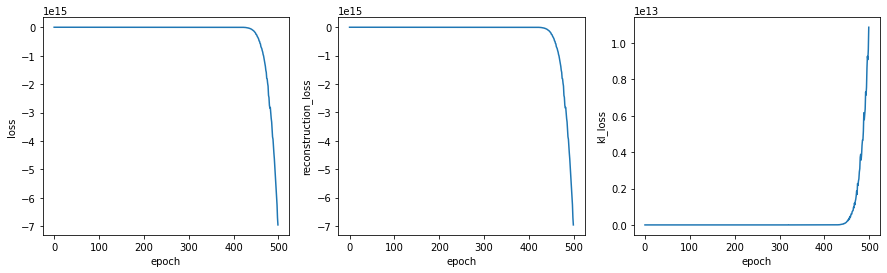

In [13]:
row = 1
col = 3
fig, ax = plt.subplots(row, col, figsize=(15,4))
ax[0].plot(history.history["loss"])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[1].plot(history.history["reconstruction_loss"])
ax[1].set_ylabel('reconstruction_loss')
ax[1].set_xlabel('epoch')
ax[2].plot(history.history["kl_loss"])
ax[2].set_ylabel('kl_loss')
ax[2].set_xlabel('epoch')
plt.show()

In [14]:
# 2022年以降を検証データにする
funds_valid= fundsdata.query('date >= 20200101')
valid_dif = funds_valid[ ['jp_stock','foreign_stock','emerging_stock','jp_bond','foreign_bond','emerging_bond','jp_reit','foreign_reit'] ]
valid_dif.reset_index(inplace=True, drop=True)
funds_dif = np.log(funds_dif)-np.log(funds_dif.shift(1))
valid_dif = valid_dif.loc[1:]

In [15]:
# ウィンドウ区間の変化率をndarrayに変換
vlist = []
for i in range(len(valid_dif.index) - w):
    vlist.append(valid_dif.loc[i+1:i+w].values)

In [16]:
x_valid = np.stack(vlist,0)

In [17]:
# vae = VAE(encoder, decoder)
# vae.compile(optimizer=keras.optimizers.Adam())
# vae.built = True
# vae.load_weights("vae.h5")

x_input = np.expand_dims(x_valid,-1)
x_decode = vae.predict(x_input)

23/23 [==============================] - 0s 9ms/step


In [ ]:
x_decode[0,:,:,:]

In [89]:
out=vae.predict(x2)

NotImplementedError: in user code:

    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 588, in call
        raise NotImplementedError(

    NotImplementedError: Exception encountered when calling layer 'vae' (type VAE).
    
    Unimplemented `tf.keras.Model.call()`: if you intend to create a `Model` with the Functional API, please provide `inputs` and `outputs` arguments. Otherwise, subclass `Model` with an overridden `call()` method.
    
    Call arguments received by layer 'vae' (type VAE):
      • inputs=tf.Tensor(shape=(None, 8), dtype=float32)
      • training=False
      • mask=None


In [87]:
deout=vae.decoder.predict(out)

ValueError: in user code:

    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/training.py", line 2079, in predict_step
        return self(x, training=False)
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/nske/miniconda3/envs/jp38/lib/python3.8/site-packages/keras/engine/input_spec.py", line 216, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "decoder" expects 1 input(s), but it received 3 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, 2) dtype=float32>, <tf.Tensor 'IteratorGetNext:2' shape=(None, 2) dtype=float32>]
